<a href="https://colab.research.google.com/github/suren777/Ml-AI-in-finance/blob/master/pricing_payground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  print("Not a collab")
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from time import time

TensorFlow 2.x selected.


In [0]:
def stoch_process_1step(s0, r, vol, dt):
    return s0*np.exp((r-0.5*vol**2)*dt + vol *np.sqrt(dt) * np.random.normal())
    
def generate_path(n_days, s0, r, vol):
    dt=1/252.0
    path = [s0]
    for i in range(n_days):
        path.append(stoch_process_1step(path[-1], r, vol, dt))
    return np.array(path)

def generate_n_paths(n_paths, n_days, s0, r, vol):
    paths = []
    for i in range(n_paths):
        paths.append(generate_path(n_days, s0, r, vol))
    return np.array(paths)

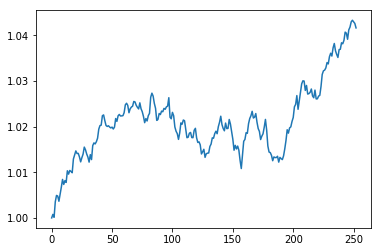

In [0]:
s0=1.0
n_days = 252
r = 0.01
vol = 0.02
_ = plt.plot(generate_path(n_days, s0, r, vol))

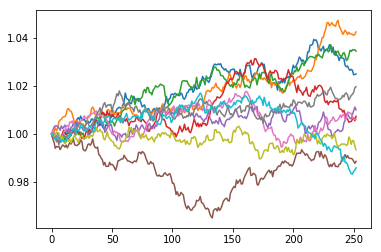

In [0]:
n_paths = 10
paths = generate_n_paths(n_paths, n_days, s0, r, vol)
_ = plt.plot(paths.T)

In [0]:
paths.shape

(10, 253)

In [0]:
# n_paths = 10000
# paths = generate_n_paths(n_paths, n_days, s0, r, vol)
# sim_forward = np.average(paths[:, -1])
# real_forward = s0*np.exp((r-0.5*vol**2)*n_days/252.0)
# print("Real Forward:{0}, Sim Forward{1}, Diff = {2}".format(sim_forward, real_forward, real_forward - sim_forward))

In [0]:
def generate_n_paths_new(n_paths, n_days, s0, r, vol, dt):
    vsq = np.sqrt(dt)*vol
    det = (r-0.5*vol**2)*dt
    noise = vsq * np.random.normal(size=(n_paths,n_days))
    paths = np.ones(shape=(n_paths,1))*s0
    paths = np.append(paths, np.exp(np.cumsum(noise+det, axis=1)), axis=1)
    return paths

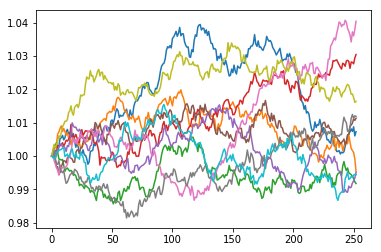

In [0]:
new_paths = generate_n_paths_new(10, n_days, s0, r, vol, 1/252)
_ = plt.plot(new_paths.T)

In [0]:
n_paths = 10000
dt = 1.0/252
paths = generate_n_paths_new(n_paths, n_days, s0, r, vol, dt)
sim_forward = np.average(paths[:, -1])
real_forward = s0*np.exp((r-0.5*vol**2)*n_days/252.0)
print("Real Forward:{0}, Sim Forward{1}, Diff = {2}".format(sim_forward, real_forward, real_forward - sim_forward))

Real Forward:1.010021568767068, Sim Forward1.009848177250408, Diff = -0.00017339151665995978


In [0]:
%timeit generate_n_paths_new(n_paths, n_days, s0, r, vol, dt)
# %timeit generate_n_paths(n_paths, n_days, s0, r, vol)

1 loop, best of 3: 217 ms per loop


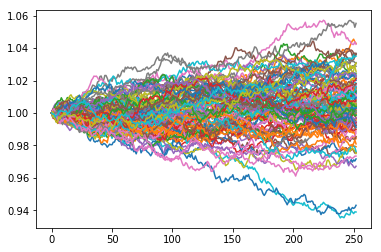

In [0]:
_ = plt.plot(paths[::100,:].T)

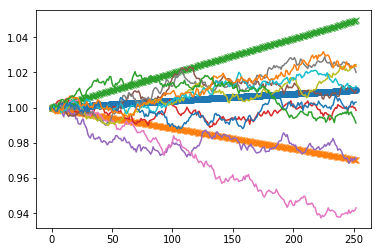

In [0]:
forwards_along = np.average(paths,axis=0)
dts = np.array([np.sqrt(dt * (day+1)) for day in range(n_days+1)])
vars_along = 1.96 * np.std(paths, axis=0)*dts

_ = plt.plot(forwards_along, marker='o')
_ = plt.plot(forwards_along - vars_along, marker='x')
_ = plt.plot(forwards_along + vars_along, marker='x')
_ = plt.plot(paths[::1000,:].T)

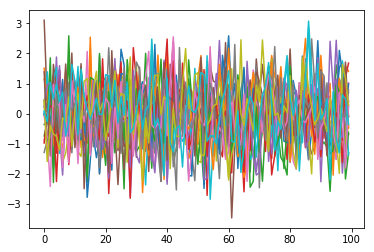

In [0]:
def generate_correlated_noise(n_samples,n_points, correlation):
    path_1 = np.random.normal(size=(n_samples, n_points))
    path_2 = path_1*correlation + np.sqrt(1-correlation**2)* np.random.normal(size=(n_samples, n_points))
    return path_1, path_2
path_1, path_2 = generate_correlated_noise(10,100, 0.5)
_ = plt.plot(path_1.T)
_ = plt.plot(path_2.T)

In [0]:
def heston_path(s0, v0, kappa, theta, eta, sv_corr, n_paths, n_days, dt):
    noise_spot, noise_vol = generate_correlated_noise(n_paths, n_days, sv_corr)
    log_spots = np.full(shape=(n_paths, n_days+1), fill_value=np.log(s0))
    vols = np.full(shape=(n_paths, n_days+1), fill_value=v0)
    kdt = kappa*theta*dt
    zdt = eta * np.sqrt(dt)
    

    for i in range(1,n_days+1):
        vols[:,i] = vols[:,i-1] *(1.0-dt)+kdt+zdt*np.sqrt(vols[:,i-1])*zdt*noise_vol[:,i-1]
        log_spots[:,i] = log_spots[:,i-1] - 0.5 * vols[:,i-1] * dt + np.sqrt(vols[:,i-1])*np.sqrt(dt)*noise_spot[:,i-1]
    return np.exp(log_spots), vols

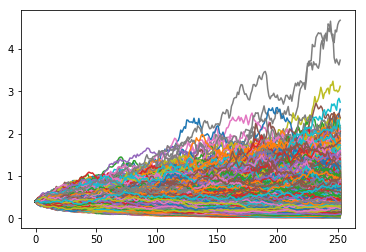

In [0]:
v0 = 0.4
kappa = 5
theta = 0.09
eta = 2
sv_corr = - 0.3
s0 = 0.4
spots, vols = heston_path(s0, v0, kappa, theta, eta, sv_corr, n_paths, n_days, dt)
_ = plt.plot(spots.T)

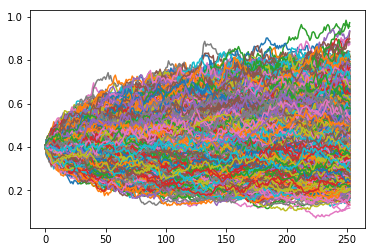

In [0]:
_ = plt.plot(vols.T)